<a href="https://colab.research.google.com/github/pnjha/NLP-Assignments/blob/master/nlp_q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 46kB/s 
     |████████████████████████████████| 419kB 20.3MB/s 
     |████████████████████████████████| 3.0MB 28.2MB/s 


In [2]:
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib.pyplot import *
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import copy
import math
import seaborn as sns; sns.set()
import keras as keras
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, Activation, dot, concatenate, Bidirectional
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [5]:
X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.en', names=['src'])
Y_in = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_in'])
Y_out = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_out'])
lines = pd.concat([X[:20],Y_in[:20],Y_out[:20]], axis=1)
print(len(lines))
# lines = shuffle(lines)
lines.sample(10)

20


,src,dest_in,dest_out
13,Main symptoms on appearance of which a patient...,प्रमुख लक्षण जिनके प्रकट होने पर रोगी को डॉक्ट...,प्रमुख लक्षण जिनके प्रकट होने पर रोगी को डॉक्ट...
4,Lens is fitted in the capsular bag .,कैपस्यूलर बैग में लैन्स फिट किया जाता है ।,कैपस्यूलर बैग में लैन्स फिट किया जाता है ।
12,Internal pressure keeps on increasing and the ...,अंदर का दबाव बढ़ता जाता है और नेत्र तंत्रिका न...,अंदर का दबाव बढ़ता जाता है और नेत्र तंत्रिका न...
5,In the S . . . . -LRB- Small Incision Cataract...,S.I.C.S ( Small Incision Cataract Surgry ) विध...,S.I.C.S ( Small Incision Cataract Surgry ) विध...
7,In black cataract the eye nerves dilapidates g...,काला मोतियाबिंद में नेत्र तंत्रिका धीरे -धीरे ...,काला मोतियाबिंद में नेत्र तंत्रिका धीरे -धीरे ...
8,The blindness caused by the black cataract can...,काले मोतियाबिंद से होने वाली अधंता अंधता को रो...,काले मोतियाबिंद से होने वाली अधंता अंधता को रो...
15,We will check the eye nerves with special lens...,विशेष लैन्स या यंत्र के द्वारा नेत्र तंत्रिका ...,विशेष लैन्स या यंत्र के द्वारा नेत्र तंत्रिका ...
1,Complete lens capsule is taken out in the meth...,इन्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन ( Intra ...,इन्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक्शन ( Intra ...
11,In most of the patients the part of the water ...,अधिकांश मरीजों में आँख से पानी जाने का हिस्सा ...,अधिकांश मरीजों में आँख से पानी जाने का हिस्सा ...
9,When the extra pressure is more in the eyes .,जब आँखों में अतिरिक्त दबाव ज्यादा हो ।,जब आँखों में अतिरिक्त दबाव ज्यादा हो ।


In [0]:
def process_data(data,append_char):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: x.strip())
    data = data.apply(lambda x: re.sub("'", '', x))
    exclude = set(string.punctuation) # Set of all special characters
    data = data.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    data = data.apply(lambda x: x.translate(remove_digits))
    if append_char == 1:
        data = data.apply(lambda x : '<sos> '+ x)
    elif append_char == 2:
        data = data.apply(lambda x : x + ' <eos>')
    return data

In [57]:
lines.src = process_data(lines.src,0)
lines.dest_in = process_data(lines.dest_in,1)
lines.dest_out = process_data(lines.dest_out,2)
lines.src.sample(10),lines.dest_in.sample(10),lines.dest_out.sample(10)

(11    in most of the patients the part of the water ...
 8     the blindness caused by the black cataract can...
 12    internal pressure keeps on increasing and the ...
 2     during operation lens is implanted at front of...
 7     in black cataract the eye nerves dilapidates g...
 0     the treatment of cataract is possible through ...
 3     in the extra capsular cataract method  the par...
 6     no stitches are applied in the s     lrb small...
 1     complete lens capsule is taken out in the meth...
 10    if somebody suffers from black cataract in the...
 Name: src, dtype: object,
 18    <sos> sos विटामिनए की कमी से कॉर्नियल कमजोर तथ...
 14    <sos> sos रोशनी मे इंद्र धनुष के समान रंगीन गो...
 10    <sos> sos यदि परिवार में किसी को काला मोतियाबि...
 5     <sos> sos sics  small incision cataract surgry...
 4     <sos> sos कैपस्यूलर बैग में लैन्स फिट किया जात...
 3     <sos> sos इक्स्ट्रा कैनसूलर कैटरेक्ट एक्सट्रेक...
 9      <sos> sos जब आँखों में अतिरिक्त दबाव ज्यादा हो ।
 1  

In [0]:
X, y_in, y_out = lines.src.values, lines.dest_in.values, lines.dest_out.values 
X_train, X_test, y_in_train, y_in_test, y_out_train, y_out_test = train_test_split(X, y_in, y_out, test_size = 0.2,shuffle=False)

In [0]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(X_train)

data_src = src_tokenizer.texts_to_sequences(X_train)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,padding='post')

In [60]:
dest_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

dest_tokenizer.fit_on_texts(y_in_train)
dest_tokenizer.fit_on_texts(y_out_train)

data_dest_in = dest_tokenizer.texts_to_sequences(y_in_train)
data_dest_in = tf.keras.preprocessing.sequence.pad_sequences(data_dest_in,padding='post')

data_dest_out = dest_tokenizer.texts_to_sequences(y_out_train)
data_dest_out = tf.keras.preprocessing.sequence.pad_sequences(data_dest_out,padding='post')

print(data_dest_in.shape)
print(data_dest_out.shape)

(16, 39)
(16, 39)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm_1(embed, initial_state=states)
        output, state_h, state_c = self.lstm_2(output, initial_state=[state_h,state_c])
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [0]:
class LuongAttention(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class LuongAttentionDot(tf.keras.Model):
    def __init__(self, lstm_size):
        super(LuongAttentionDot, self).__init__()
        self.wa = tf.keras.layers.Dense(lstm_size)

    def call(self, decoder_output, encoder_output):
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        attention_weights = tf.nn.softmax(score, axis=2)
        context_vector = tf.matmul(attention_weights, encoder_output)
        return context_vector, attention_weights

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(lstm_size)
    self.W2 = tf.keras.layers.Dense(lstm_size)
    self.V = tf.keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    
    score = self.V(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output)))
    score = tf.transpose(score,perm=[0,2,1])
    
    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    return context_vector, attention_weights

In [0]:
class BahdanauAttentionCoverage(tf.keras.Model):
  def __init__(self, lstm_size):
    super(BahdanauAttentionCoverage, self).__init__()
    self.coverage = None
    self.W1 = tf.keras.layers.Dense(lstm_size,name="W1")
    self.W2 = tf.keras.layers.Dense(lstm_size,name="W2")
    self.W3 = tf.keras.layers.Dense(lstm_size,name="W3")
    self.W4 = tf.keras.layers.Dense(lstm_size,name="W4")
    self.W5 = tf.keras.layers.Dense(lstm_size,name="W5")
    self.W6 = tf.keras.layers.Dense(lstm_size,name="W6")
    self.W7 = tf.keras.layers.Dense(lstm_size,name="W7")
    self.V1 = tf.keras.layers.Dense(1,name="V1")
    self.V2 = tf.keras.layers.Dense(1,name="V2")

  def call(self, decoder_output, encoder_output):
    
    if self.coverage is None: 
      self.coverage = decoder_output

    score = self.V1(tf.nn.tanh(self.W1(decoder_output) + self.W2(encoder_output) + self.W3(self.coverage)))
    score = tf.transpose(score,perm=[0,2,1])
    
    self.coverage = self.V1(tf.nn.tanh(self.W4(decoder_output) + self.W5(encoder_output) + self.W6(self.coverage)))
    self.coverage = tf.reshape(self.coverage, tf.shape(encoder_output).numpy())
    # print(self.coverage.shape, decoder_output.shape, encoder_output.shape)


    attention_weights = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(attention_weights, encoder_output)
    # print(score.shape,decoder_output.shape,encoder_output.shape,attention_weights.shape,context_vector.shape)
    return context_vector, attention_weights


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size, attn_type):
        super(Decoder, self).__init__()

        if attn_type == 'LuongAttention':
          self.attention = LuongAttention(lstm_size)
        elif attn_type == 'LuongAttentionDot':
          self.attention = LuongAttentionDot(lstm_size)
        elif attn_type == 'BahdanauAttention':
          self.attention = BahdanauAttention(lstm_size)
        elif attn_type == 'BahdanauAttentionCoverage':
          self.attention = BahdanauAttentionCoverage(lstm_size)
        
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(lstm_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):

        embed = self.embedding(sequence)
        
        lstm_out, state_h, state_c = self.lstm_1(embed, initial_state=state)
        lstm_out, state_h, state_c = self.lstm_2(lstm_out, initial_state=[state_h,state_c])
        context, alignment = self.attention(lstm_out, encoder_output)

        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [67]:
c = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(c.shape)
# repeat(c, repeats=[1, 3], axis=1) 

(2, 3)


In [0]:
BATCH_SIZE = 2
EMBEDDING_SIZE = 256
LSTM_SIZE = 256

In [69]:
dataset = tf.data.Dataset.from_tensor_slices((data_src, data_dest_in, data_dest_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 31), (None, 39), (None, 39)), types: (tf.int32, tf.int32, tf.int32)>


In [0]:
def get_model(attn_type):
  src_vocab_size = len(src_tokenizer.word_index) + 1
  dest_vocab_size = len(dest_tokenizer.word_index) + 1

  encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  decoder = Decoder(dest_vocab_size, EMBEDDING_SIZE, LSTM_SIZE,attn_type)
  return encoder, decoder

In [0]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

In [0]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=0.2)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [0]:
def train_step(model,source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    encoder = model["encoder"]
    decoder = model["decoder"]
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        for i in range(target_seq_out.shape[1]):          
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]

In [0]:
def train_model(attn_type,NUM_EPOCHS):
  encoder, decoder = get_model(attn_type)
  model = {"encoder":encoder,"decoder":decoder}
  loss_list = []
  ep_list = []

  en_initial_states = encoder.init_states(BATCH_SIZE)
  for e in range(NUM_EPOCHS):
  
      for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          loss = train_step(model, source_seq, target_seq_in,target_seq_out, en_initial_states)
      
      ep_list.append(e+1)
      loss_list.append(loss.numpy())
      print('Epoch {} Loss {:.8f}'.format(e + 1, loss.numpy()))
  return encoder, decoder, loss_list, ep_list

In [0]:
def predict(model,test_source_text):
    
    encoder = model["encoder"]
    decoder = model["decoder"]
    src_tokenizer = model["src_tokenizer"]
    dest_tokenizer = model["dest_tokenizer"]

    test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[dest_tokenizer.word_index['<sos>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        try:
          out_words.append(dest_tokenizer.index_word[de_input.numpy()[0][0]])
        except:
          out_words.append('<unk>')
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 50:
            break

    out_words = ' '.join(out_words)
    return np.array(alignments), out_words

In [0]:
def calculate_bleu_score(actual_string, predicted_string):
    actual_string = copy.deepcopy(actual_string)
    predicted_string = copy.deepcopy(predicted_string)
    reference = re.split("\s",actual_string.strip())
    candidate = re.split("\s",predicted_string.strip())
    try:
      reference.remove('<eos>')
      candidate.remove('<sos>')
    except:
      pass
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

In [0]:

def plot_graph(xlist,ylist,xname,yname):
  x = np.array(xlist)
  y = np.array(ylist)
  d = {xname: x, yname: y}
  data = pd.DataFrame(d)
  sns.lineplot(x=xname, y=yname,data = data)
  plt.show()

In [0]:
def get_prediction(X,y,model):
  for index,line in enumerate(X):
    alignment, output = predict(model,line)
    print("source: ",line)
    print("actual: ",y[index])
    print("predicted: ",output)
    print("BLEU Score: ",calculate_bleu_score(output,y[index]))
    ax = sns.heatmap(alignment[:,0,0,:],linewidths=.2,cmap="YlGnBu")
    plt.show()

Epoch 1 Loss 1.79245889
Epoch 2 Loss 2.09652448
Epoch 3 Loss 1.70728028


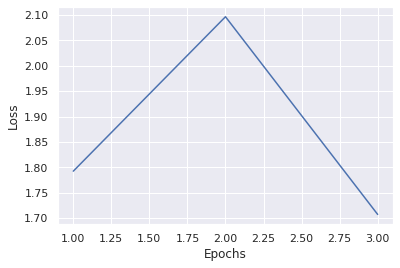

In [82]:
# attn_type = 'BahdanauAttention'
# attn_type = 'LuongAttentionDot'
attn_type = 'LuongAttention'
# attn_type = 'BahdanauAttentionCoverage'

NUM_EPOCHS = 3
encoder, decoder, loss_list,epoch_list = train_model(attn_type,NUM_EPOCHS)
model = {"encoder":encoder, "decoder":decoder, "attn_type":attn_type, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}
# model = { "attn_type":attn_type, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}

plot_graph(epoch_list,loss_list,"Epochs","Loss")


In [80]:
get_prediction(X_test,y_in_test,model)
# get_prediction(X_train,y_in_train, model)

KeyError: ignored

In [0]:
import dill
import pickle
import weakref

nameoffile = "q4"
with open(nameoffile, "wb") as dill_file:
    dill.dump(model, dill_file)

In [0]:
model = {}
with open(nameoffile, "rb") as dill_file:
  model = dill.load(dill_file)

In [87]:
print(model['attn_type'])

LuongAttention
